In [456]:
# We need to install TensorFlow first
from yahoofinancials import YahooFinancials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
from keras.models import Sequential
from keras.layers import * 
from scipy.stats import pearsonr

#For reproducability
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [452]:
def plot_predictions(test,predicted, symbol, model_name):
    plt.plot(test, color='red', label=f'Real {symbol} Stock Price')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price by {model_name}')
    plt.title(f'{symbol} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price')
    plt.legend()
    plt.show()

def plot_return_predictions(test,predicted,symbol):
    plt.plot(test, color='red',label=f'Real {symbol} Stock Price Returns')
    plt.plot(predicted, color='blue',label=f'Predicted {symbol} Stock Price Return')
    plt.title(f'{symbol} Stock Return Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{symbol} Stock Price Returns')
    plt.legend()
    plt.show()
    
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse

def return_mae(test,predicted):
    mae = np.mean(np.abs(predicted-test))
    return(mae)

def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr)*pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

def scheduler(epoch, lr):
    if epoch < 10:
        return(lr)
    else:
        return(lr*tf.math.exp(-0.1))

In [405]:
def get_ticker_data(ticker: str, param_start_date, param_end_date) -> dict:
    raw_data = YahooFinancials(ticker)
    return raw_data.get_historical_price_data(param_start_date, param_end_date, "daily").copy()

def fetch_ticker_data(ticker: str, start_date, end_date) -> pd.DataFrame:
    date_range = pd.bdate_range(start=start_date, end=end_date)
    values = pd.DataFrame({'Date': date_range})
    values['Date'] = pd.to_datetime(values['Date'])
    raw_data = get_ticker_data(ticker, start_date, end_date)
    return pd.DataFrame(raw_data[ticker]["prices"])[['date', 'open', 'high', 'low', 'adjclose', 'volume']]

def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = 1.1*xs[n-1] if xs[n-1]>xs[n-2] else 0.9*xs[n-1]
        e[n:] = xs[:-n]
    else:
        e[n:] = 1.1*xs[n] if xs[n]>xs[n-1] else 0.9*xs[n]
        e[:n] = xs[-n:]
    return(e)

def MAPE(prd,obs):
    Sum = 0
    for i,j in zip(prd,obs):
      Sum += abs(j-i)/j
    mape = (100/len(prd))*Sum
    print("The mean absolute percentage error (MAPE) is: ", np.round(mape,3), "%")

### In the symbol to fetch you choose the name of the stock you want to predict

In [675]:
# # Choose a stock symbol
symbol_to_fetch = 'AMZN'  
# Choose a date range
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
# Get Stock Price Data
stock = fetch_ticker_data(symbol_to_fetch, start_date, end_date)
stock.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
stock['DateTime'] = stock['DateTime'].apply(lambda x: datetime.fromtimestamp(x))
stock = stock.fillna(method="ffill", axis=0)
stock = stock.fillna(method="bfill", axis=0)
stock = stock.set_index('DateTime')

stock['Symbol'] = symbol_to_fetch
stock.tail()
#save a copy for later testing
original_stock = stock
original_symbol = symbol_to_fetch

original_stock['Close'].tail()

DateTime
2023-01-09 15:30:00    87.360001
2023-01-10 15:30:00    89.870003
2023-01-11 15:30:00    95.089996
2023-01-12 15:30:00    95.269997
2023-01-13 15:30:00    98.120003
Name: Close, dtype: float64

In [677]:
print(start_date)
print(end_date)

2020-01-01
2023-01-16


In [678]:
target = 'Close' # this is accessed by .iloc[:,3:4].values below
begin = 3
train_start_date = start_date
train_end_date = '2022-06-30'
test_start_date = '2022-07-01'
training_set = stock[train_start_date:train_end_date].iloc[:,begin:4].values
test_set = stock[test_start_date:].iloc[:,begin:4].values

#test_set_return = stock[test_start_date:].iloc[:,3:4].pct_change().values
#log_return_test = np.log(test_set_return)

print(training_set.shape)
print(test_set.shape)

(629, 1)
(136, 1)


In [679]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

timestep = 10
# First, we create data sets where each sample has with 8 timesteps and 1 output
# So for each element of training set, we have 8 previous training set elements 
x_train = []
y_train = []
for i in range(timestep,training_set.shape[0]):
    x_train.append(training_set_scaled[i-timestep:i,:])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], training_set_scaled.shape[1]))
print(x_train.shape)

(619, 10, 1) (619,)
(619, 10, 1)


In [680]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # x = layers.Dense(ff_dim, activation="elu")(x) # MINE!!!!
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [681]:
def build_model(input_shape, head_size, num_heads,ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):

    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) # this is a pass-through
    return keras.Model(inputs, outputs)

In [682]:
callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True), keras.callbacks.LearningRateScheduler(lr_scheduler)]
input_shape = x_train.shape[1:]
print(input_shape)

(10, 1)


In [683]:
model = build_model(
    input_shape,
    head_size=64, # Embedding size for attention
    num_heads=16, # Number of attention heads
    ff_dim=128, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.3,
    dropout=0.15)

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["mean_squared_error"])
#model.summary()

In [701]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=callbacks)
print("FINISHED TRAINING")

Epoch 1/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - lr: 1.0000e-06
Epoch 2/10
16/16 [==============================] - 2s 144ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - lr: 3.4300e-05
Epoch 3/10
16/16 [==============================] - 2s 150ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - lr: 6.7600e-05
Epoch 4/10
16/16 [==============================] - 3s 177ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - lr: 1.0090e-04
Epoch 5/10
16/16 [==============================] - 3s 216ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - lr: 1.3420e-04
Epoch 6/10
16/16 [==============================] - 4s 218ms/step - loss: 0.0040 - mean_squared_error: 0.

In [695]:
train_test_data = training_set_scaled[-timestep:,:]
print(train_test_data.shape)
test_set_scaled = sc.fit_transform(test_set)
print(test_set_scaled.shape)
test_inputs = np.concatenate((train_test_data,test_set_scaled), axis=0)
print((test_inputs.shape))
x_test = []
for i in range(timestep,test_inputs.shape[0]):
    x_test.append(test_inputs[i-timestep:i,:])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], test_set_scaled.shape[1]))
print(x_test.shape)

(10, 1)
(136, 1)
(146, 1)
(136, 10, 1)


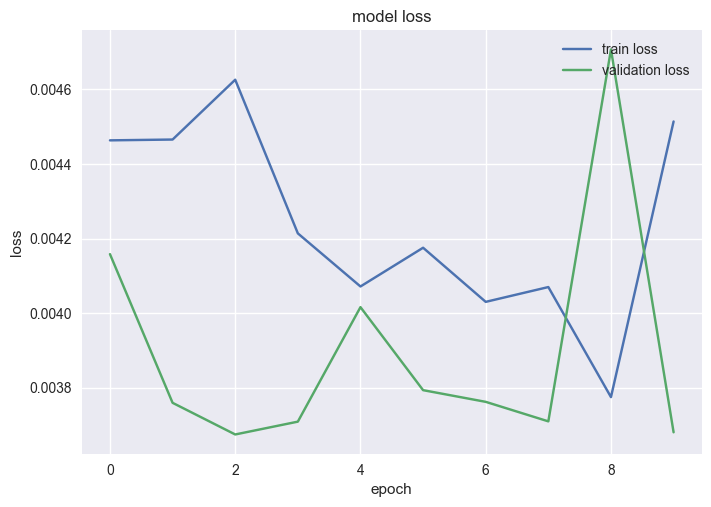

In [696]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [705]:
predicted_stock_price = shift(model.predict(x_test),-2)
if(test_set_scaled.shape[1]>1):
    print("Multivariate")
    predicted_stock_price= np.tile(predicted_stock_price,(1, test_set_scaled.shape[1]))
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = predicted_stock_price[:,0]
    test_set = test_set[:,3]
else:
    print("Univariate")
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

5/5 [==============================] - 0s 49ms/step
Univariate


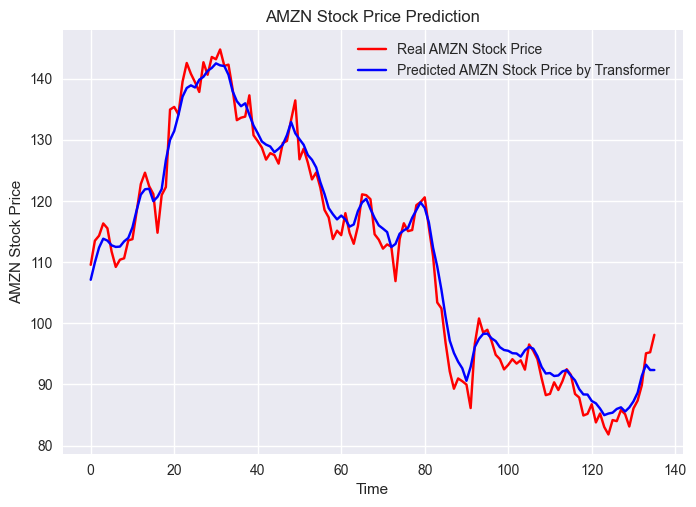

The Root Mean Squared Error (RMSE) is: 2.493589824998613.
The Mean Absolute Error (MAE) is: 2.0170655531041763.
The Pearson correlation coefficient is: 0.9923664949906608.


In [706]:
name1 = "Transformer"
plot_predictions(test_set, predicted_stock_price, original_symbol,name1)
rmse1 = return_rmse(test_set, predicted_stock_price)
mae1 = return_mae(test_set, predicted_stock_price)
rho1 = pearsonr(test_set[:,0], predicted_stock_price[:,0])[0]

print("The Root Mean Squared Error (RMSE) is: {}.".format(rmse1))
print("The Mean Absolute Error (MAE) is: {}.".format(mae1))
print("The Pearson correlation coefficient is: {}.".format(rho1))
#MAPE(predicted_stock_price[:],test_set[:])

### OTHER TYPES OF RNN

In [707]:
model_keras = Sequential()
model_keras.add(LSTM(units=256, return_sequences=False, recurrent_activation ='sigmoid', recurrent_dropout=0.0, input_shape=(x_train.shape[1], x_train.shape[2])))
model_keras.add(Dropout(0.2))
#model_keras.add(SimpleRNN(units=256, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
#model_keras.add(Dropout(0.2))
#model_keras.add(Bidirectional(LSTM(units=256, return_sequences=False)))
#model_keraS.add(Bidirectional(LSTM(units=512, recurrent_activation ='sigmoid', recurrent_dropout=0.0, unroll=False, use_bias=True, return_sequences=True)))
#model_keras.add(Dropout(0.2))
model_keras.add(Dense(units=128))
#model_keras.add(Dense(units=32))
model_keras.add(Dense(units=1))
model_keras.build(x_train.shape)
model_keras.compile(optimizer='adam',loss='mean_squared_error')
model_keras.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 256)               264192    
                                                                 
 dropout_347 (Dropout)       (None, 256)               0         
                                                                 
 dense_106 (Dense)           (None, 128)               32896     
                                                                 
 dense_107 (Dense)           (None, 1)                 129       
                                                                 
Total params: 297,217
Trainable params: 297,217
Non-trainable params: 0
_________________________________________________________________


In [708]:
import time
t_start = time.time()
history = model_keras.fit(x_train, y_train, batch_size=16, epochs=100, validation_split=0.2, callbacks=callbacks)
t_finish = time.time()
print('Runtime: %.2f s' %(t_finish-t_start))

Epoch 1/100
31/31 [==============================] - 12s 193ms/step - loss: 0.5794 - val_loss: 0.3931 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 0.3990 - val_loss: 0.1549 - lr: 3.4300e-05
Epoch 3/100
31/31 [==============================] - 1s 41ms/step - loss: 0.0775 - val_loss: 0.0118 - lr: 6.7600e-05
Epoch 4/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0066 - val_loss: 0.0089 - lr: 1.0090e-04
Epoch 5/100
31/31 [==============================] - 1s 39ms/step - loss: 0.0046 - val_loss: 0.0094 - lr: 1.3420e-04
Epoch 6/100
31/31 [==============================] - 1s 39ms/step - loss: 0.0048 - val_loss: 0.0093 - lr: 1.6750e-04
Epoch 7/100
31/31 [==============================] - 1s 38ms/step - loss: 0.0046 - val_loss: 0.0094 - lr: 2.0080e-04
Epoch 8/100
31/31 [==============================] - 1s 46ms/step - loss: 0.0042 - val_loss: 0.0081 - lr: 2.3410e-04
Epoch 9/100
31/31 [==============================] - 1s 42ms/s

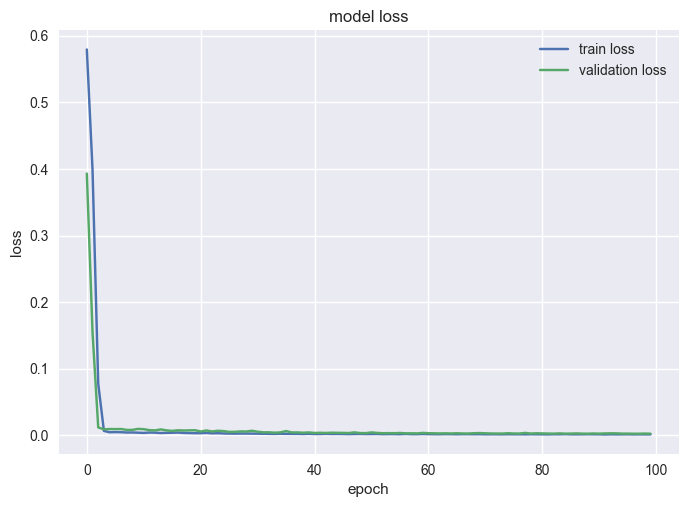

In [709]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

In [714]:
predicted_stock_price = model_keras.predict(x_test)
if(test_set_scaled.shape[1]>1):
    print("Multivariate")
    predicted_stock_price= np.tile(predicted_stock_price,(1, test_set_scaled.shape[1]))
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predicted_stock_price = predicted_stock_price[:,0]
    #test_set = test_set[:,3]
else:
    print("Univariate")
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price.shape)

5/5 [==============================] - 0s 12ms/step
Univariate
(136, 1)


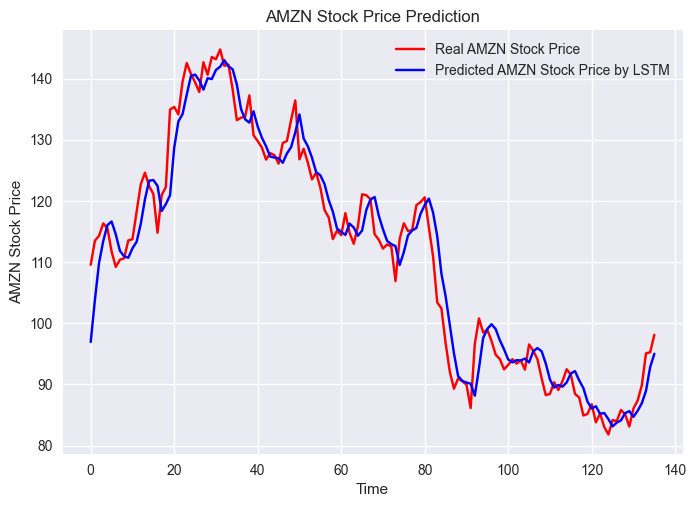

The Root Mean Squared Error (RMSE) is: 3.9811210638876755.
The Mean Absolute Error (MAE) is: 3.0157922856947956.
The Pearson correlation coefficient is: 0.9759330054948013.


In [715]:
name2 = "LSTM"
plot_predictions(test_set, predicted_stock_price, original_symbol, name2)
rmse2 = return_rmse(test_set, predicted_stock_price)
mae2 = return_mae(test_set, predicted_stock_price)
rho2 = pearsonr(test_set[:,0], predicted_stock_price[:,0])[0]

print("The Root Mean Squared Error (RMSE) is: {}.".format(rmse2))
print("The Mean Absolute Error (MAE) is: {}.".format(mae2))
print("The Pearson correlation coefficient is: {}.".format(rho2))

In [716]:
path = "C:/Users/admitos/Desktop/Visual Studio Notebooks/Time Series Transformer/Metrics/" + original_symbol +'.txt'
with open(path, 'w') as f:
    f.write(name1 + ": " + "The Root Mean Squared Error (RMSE) is: {}. \n".format(rmse1))
    f.write("\n" + name1 + ": " + "The Mean Absolute Error (MAE) is: {}. \n".format(mae1))
    f.write("\n" + name1 + ": " + "The Pearson correlation coefficient is: {}. \n".format(rho1))    
    f.write("\n")
    f.write("\n")
    f.write("-----------------------------------------------------------")
    f.write(name2 + ": " + "The Root Mean Squared Error (RMSE) is: {}. \n".format(rmse2))
    f.write("\n" + name2 + ": " + "The Mean Absolute Error (MAE) is: {}. \n".format(mae2))
    f.write("\n" + name2 + ": " + "The Pearson correlation coefficient is: {}. \n".format(rho2))